In [49]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage import exposure

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Load the MNIST dataset

In [50]:
digits = load_digits()

In [51]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


View some images in the dataset

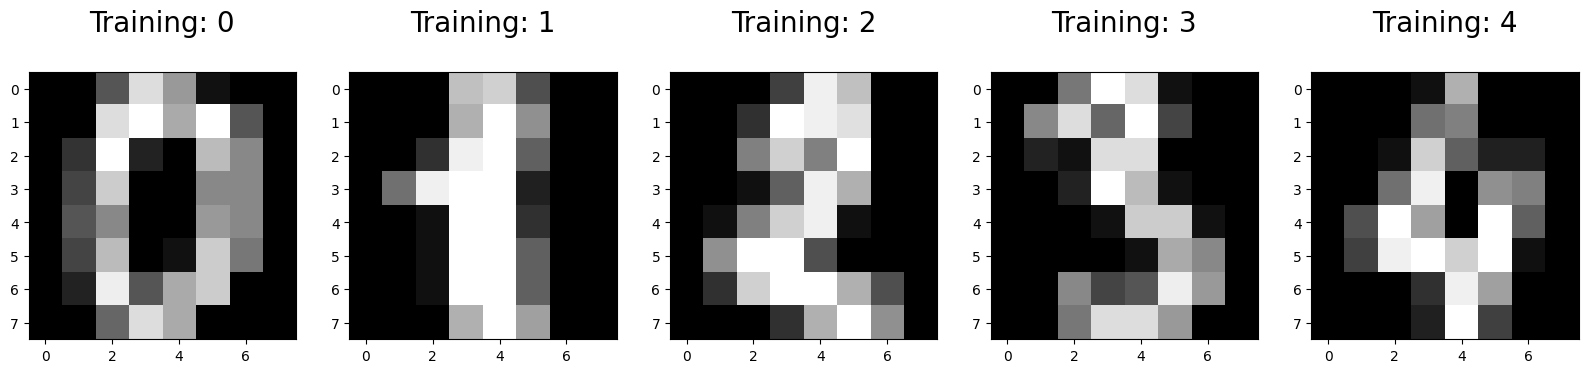

In [52]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

### Split the data into train and test sets

The data is split into 80% for training the learning model, and 20% for testing accuracy of the trained model. In this task, no separate dataset is split for hyperparameter tuning, as the whole training set (80% of data, and is not large) is used for hyperparameter tuning and training the model.

In [53]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

In [54]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1437, 64)
y_train.shape:  (1437,)
X_test.shape:  (360, 64)
y_test.shape:  (360,)


### Create a classification model with RandomForestClassifier

In [55]:
# function to evaluate the model
def evaluate_performance(classifier, X_train, y_train, x_test, y_test):
    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier's performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')   # use macro instead of weighted
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("Train accuracy: ", classifier.score(X_train,y_train))
    print('Test accuracy: ', accuracy)
    print('Test precision: ', precision)
    print('Test recall: ', recall)
    print('Test f1: ', f1)

In [56]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)  #, min_samples_split=5, n_estimators=100

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Show the model parameters
rf_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [57]:
print("Before hyperparameter tuning:")
evaluate_performance(rf_classifier, X_train, y_train, X_test, y_test)

Before hyperparameter tuning:
Train accuracy:  1.0
Test accuracy:  0.9722222222222222
Test precision:  0.9740424119023985
Test recall:  0.9727003722185199
Test f1:  0.9732067700933176


### Hyperparameter Tuning

Pick one parameter to tune as requested: min_samples_split

As the train accuracy is 1, it means the model predict the result 100% correct on the training dataset. The trained model might have been overfitted the data, I try to generalize the model to increase the accuracy of the testing model. So I change the parameters which can help to reduce overfitting.

I tried to change max_depth, n_estimators and min_samples_leaf, and min_samples_split a bit and train. The accuracy on test dataset improved the most with min_samples_split, so I further tune the model with min_samples_split in below.

In [58]:
# Note: this might take a couple of minutes to run depending on your machine
# Perform hyperparameter tuning using GridSearchCV

# Setup the parameters for searching best estimator
param_grid = {
    # 'max_depth': [None,2,5,10,20],
    # 'n_estimators': [30,50,100,200,300,500,700],
    'min_samples_split':np.arange(2,6,1),
    # 'min_samples_leaf':np.arange(1,6,1)
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1,scoring='accuracy')
grid_search.fit(X_train, y_train)

# Train the classifier with the best parameters
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

print('After hyperparameter tuning (best estimator):')
evaluate_performance(best_rf_classifier, X_train, y_train, X_test, y_test)

After hyperparameter tuning (best estimator):
Train accuracy:  1.0
Test accuracy:  0.9833333333333333
Test precision:  0.9840867381435332
Test recall:  0.9832995112938792
Test f1:  0.9836019474028443


From the best model, it shows the best value of min_samples_split value is 5. 

In [59]:
best_rf_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Try to predict and visualize the images and their predicted labels with the best estimator.

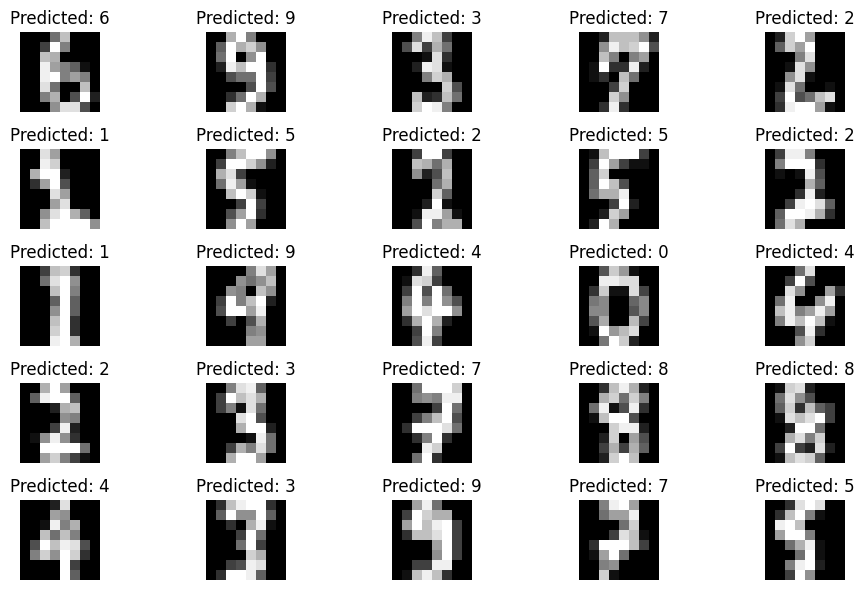

In [60]:
y_pred_best = best_rf_classifier.predict(X_test)

# Visualize some sample images and their predicted labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    image = X_test[i].reshape(8, 8)
    predicted_label = y_pred_best[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Predicted: {predicted_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Confusion matrix for the Random Forest model on the test set

From the confustion matrix below, the model struggles with 5 the most. For predictions on the test set, there are two non-5 values are predicted as 5 (False postive), and one 5 value is predicted as 6 (false negative). The other classes have less false postive than 5 does.


Text(0.5, 1.0, 'Confusion Matrix for best estimator')

<Figure size 5000x1500 with 0 Axes>

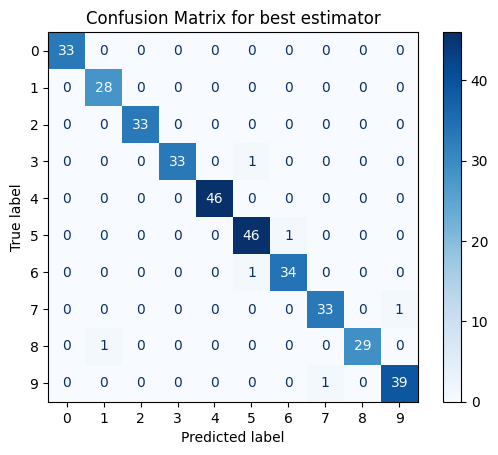

In [61]:
# Show confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_best,labels=[0,1,2,3,4,5,6,7,8,9])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(50, 15))
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix for best estimator")

### Report the accuracy, precision, recall, and f1-score of the best estimator

In [62]:
evaluate_performance(best_rf_classifier, X_train, y_train, X_test, y_test)

Train accuracy:  1.0
Test accuracy:  0.9833333333333333
Test precision:  0.9840867381435332
Test recall:  0.9832995112938792
Test f1:  0.9836019474028443
